以前我曾经写过两篇关于数字货币高频交易的两篇文章 [ 数字货币高频策略详细入门](https://www.fmz.com/digest-topic/9976), [5天赚80倍，高频策略的威力](https://www.fmz.com/digest-topic/6228)。但只能算是经验分享，泛泛而谈。本次我计划写个系列文章, 从头开始介绍高频交易的思路, 希望尽量简洁明了，但由于本人水平有限，对高频交易的理解不算深入，本文只算抛砖引玉，希望大神指正。

### 高频利润来源

以前的文章提到过，高频策略特别适合行情上下波动非常剧烈的行情。考察一个交易品种在短时间内的价格变化，由总的趋势和震荡组成。如果我们能准确的预测趋势的变化，当然能够赚钱，但这也是最难的，本文主要介绍高频的maker策略，将不涉及这个问题。在震荡行情中，策略上下挂单，如果成交的足够频繁，利润空间足够大，是能够覆盖因趋势造成的可能损失，这样不预测行情也能盈利。目前交易所maker成交都有手续费返佣，这也是利润的组成部分，竞争越充分，rebate所占的比例也应该也高。

### 要解决的问题

 1.策略同时挂买单和卖单，第一个问题就是在哪里挂单。挂的离盘口越近，成交的概率越高，但在剧烈波动的行情中，瞬间成交的价格可能离盘口较远，挂的那太近没有能吃到足够的利润。挂的太远的单子成交概率又低。这是一个需要优化的问题。
 
 2.控制仓位。为了控制风险，策略就不能长时间累计过多的仓位。可以通过控制挂单距离、挂单量、总仓位限制等办法解决。
 
为了能达到上面的目的，需要对成交概率概率、成交的利润、行情估计等多方面进行建模估计，这方面的文章和论文很多，以High-Frequency Trading, Orderbook等关键词可以找到。网上也有很多推荐，这里就不展开。另外最好还要建立一个可靠快速的回测系统，虽然高频策略很容易通过实盘来验证策略的有效性，但回测还是能提供更多的思路，降低试错的成本。

### 需要的数据

币安提供了逐笔成交和最优挂单数据供[下载](https://www.binance.com/en/landing/data)，深度数据需要在白名单中用API下载，也可以自己收集。回测用途使用归集的成交数据就可以。本文以HOOKUSDT-aggTrades-2023-01-27的数据为例。

In [1]:
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

逐笔成交有以下列：

1. agg_trade_id：归集成交单的id，	
2. price：成交价
3. quantity：成交的数量
4. first_trade_id：归集交易可能有几笔同时成交，只统计一条数据，这是第一笔成交的id
5. last_trade_id：最后成交的id
6. transact_time：成交时间
7. is_buyer_maker：成交方向，True代表买单maker成交，卖单是taker

可以看到当天有66万条成交数据，成交很活跃。csv将附在评论区。

In [4]:
trades = pd.read_csv('COMPUSDT-aggTrades-2023-07-02.csv')
trades

agg_trade_id  price  quantity  first_trade_id  last_trade_id  \
0          120719552  52.42    22.087       207862988      207862990   
1          120719553  52.41    29.314       207862991      207863002   
2          120719554  52.42     0.945       207863003      207863003   
3          120719555  52.41    13.534       207863004      207863006   
4          120719556  52.41    64.073       207863007      207863008   
...              ...    ...       ...             ...            ...   
664470     121384022  68.27    22.673       210364884      210364890   
664471     121384023  68.28   116.023       210364891      210364898   
664472     121384024  68.29    10.065       210364899      210364905   
664473     121384025  68.30     7.078       210364906      210364908   
664474     121384026  68.29     7.622       210364909      210364911   

        transact_time  is_buyer_maker  
0       1688256004603           False  
1       1688256004623            True  
2       1688256004678           False  
3       1688256004680            True  
4       1688256004692           False  
...               ...             ...  
664470  1688342399732           False  
664471  1688342399801           False  
664472  1688342399863           False  
664473  1688342399948           False  
664474  1688342399979            True  

[664475 rows x 7 columns]

### 单笔成交量建模

先对数据进行处理，把原始的trades分为了买单主动成交组和卖单主动成交组。另外原始聚合交易的数据是同一时间同一个价格同一方向为一条数据，可能会发生一笔主动的买单量为100，如果分为多笔成交且价格不一样，如分为了60和40两笔，会产生两条数据，影响买单成交量的估计。因此在需要根据transact_time再聚合一次。聚合后数据量减少了14万条。

In [6]:
trades['date'] = pd.to_datetime(trades['transact_time'], unit='ms')
trades.index = trades['date']
buy_trades = trades[trades['is_buyer_maker']==False].copy()
sell_trades = trades[trades['is_buyer_maker']==True].copy()
buy_trades = buy_trades.groupby('transact_time').agg({
    'agg_trade_id': 'last',
    'price': 'last',
    'quantity': 'sum',
    'first_trade_id': 'first',
    'last_trade_id': 'last',
    'is_buyer_maker': 'last',
    'date': 'last',
    'transact_time':'last'
})
sell_trades = sell_trades.groupby('transact_time').agg({
    'agg_trade_id': 'last',
    'price': 'last',
    'quantity': 'sum',
    'first_trade_id': 'first',
    'last_trade_id': 'last',
    'is_buyer_maker': 'last',
    'date': 'last',
    'transact_time':'last'
})
buy_trades['interval']=buy_trades['transact_time'] - buy_trades['transact_time'].shift()
sell_trades['interval']=sell_trades['transact_time'] - sell_trades['transact_time'].shift()

In [10]:
print(trades.shape[0] - (buy_trades.shape[0]+sell_trades.shape[0]))

146181


以买单为例，先画出直方图，可以看到长尾效应非常明显，大部分数据集中在最左侧一点，但也有少量的大成交分布在尾巴上。

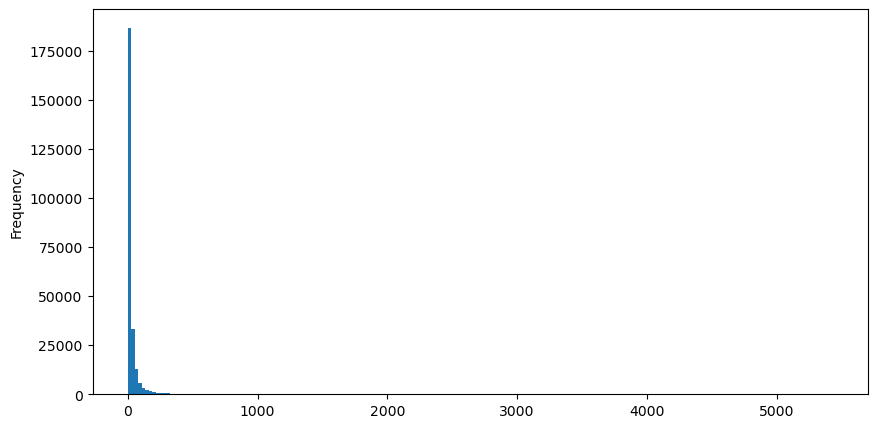

In [36]:
buy_trades['quantity'].plot.hist(bins=200,figsize=(10, 5));

为了观察方便，截掉尾部观察.可以看到成交量越大，出现频率越低，且减少的趋势更快。

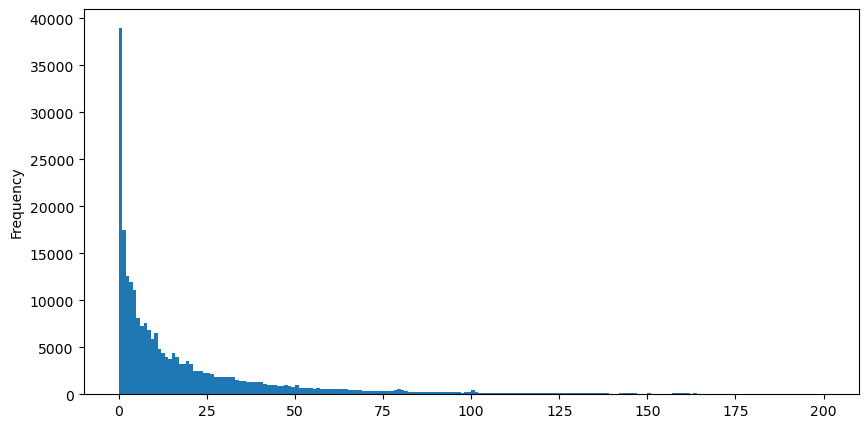

In [37]:
buy_trades['quantity'][buy_trades['quantity']<200].plot.hist(bins=200,figsize=(10, 5));

关于成交量满足的分布相关研究很多。其满足幂律分布（Power-law distribution）又叫帕累托分布，是统计物理学和社会科学中常见的一种概率分布形式。在幂律分布中，事件的大小（或频率）的概率正比于该事件大小的某个负指数。这种分布形式的主要特点是大事件（即那些远离平均值的事件）的发生频率比在许多其他分布中预期的要高。这正是成交量分布的特点。帕累托分布的形式为：P(x) = Cx^(-α)。下面将实证下。

下面这张图表示成交量大于某个值的概率，蓝线为实际概率，橙线为模拟的概率，这里先不要纠结具体的参数，可以看到样子确实很满足帕累托分布。由于订单量大于0的概率为1，且为了满足标准化，其分布方程形式应该如下：

$$P(q\geq D) = (1+\frac{D}{N})^{alpha}$$

其中N为标准化的参数。这里选择平均成交量M，alpha选择-2.06 。具体alpha的估计可以通过当D=N是的P值反算出。具体的：alpha = log(P(d>M))/log(2) 。选择不同的点alpha取值会稍有差异。

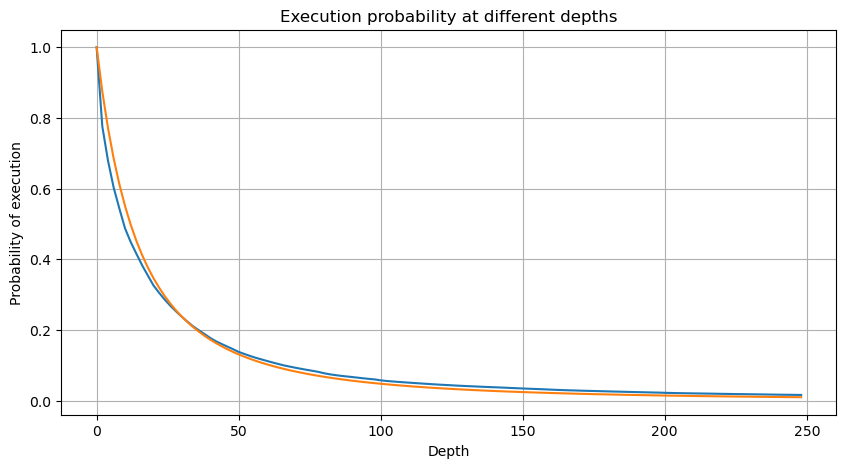

In [55]:
depths = range(0, 250, 2)
probabilities = np.array([np.mean(buy_trades['quantity'] > depth) for depth in depths])
alpha = np.log(np.mean(buy_trades['quantity'] > mean_quantity))/np.log(2)
mean_quantity = buy_trades['quantity'].mean()
probabilities_s = np.array([(1+depth/mean_quantity)**alpha for depth in depths])

plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities)
plt.plot(depths, probabilities_s)
plt.xlabel('Depth')
plt.ylabel('Probability of execution')
plt.title('Execution probability at different depths')
plt.grid(True)

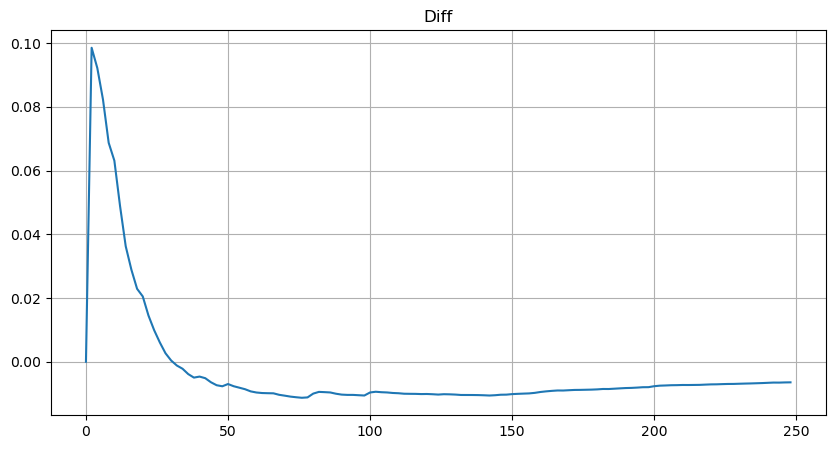

In [56]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title('Diff')
plt.plot(depths, probabilities_s-probabilities);

但这个估计只是看起来像，上图我们画出模拟值和实际值的差。当成交量较小时偏差很大，甚至接近10%。可以通过参数估计时选择不同的点来使这个点的概率更精准，但也解决不了偏离的问题。这是幂律分布和实际分布的差异决定的，为了得到更准确的结果，需要对幂律分布的方程进行修正。具体的过程不赘述，总之灵光闪过，发现实际应该如下：


$$ P\left(\frac{q}{M} \geq r\right) = \left((1 + 20^{-r}) \cdot r + 1\right)^\alpha $$

为了简介这里用r = q/M 代表标准化的成交量。可以用上面同样的方式估计参数。下面的图可以看到修正后最大偏差不超过2%, 理论上可以继续修正，但这个精度也够用了。

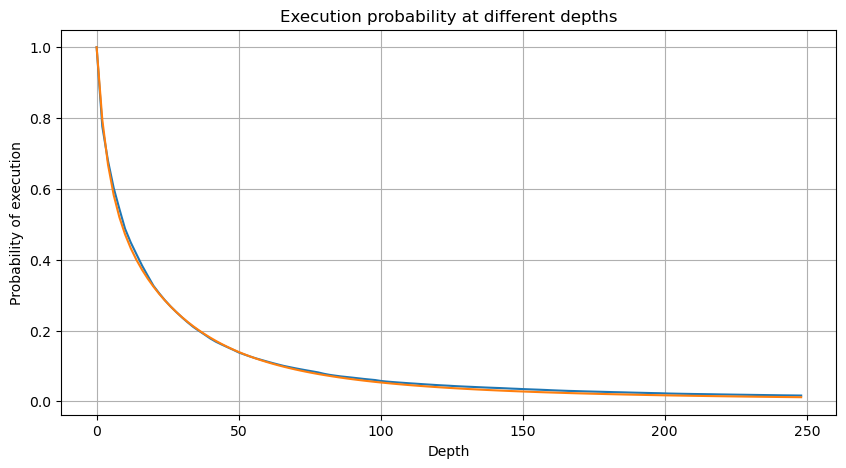

In [52]:
depths = range(0, 250, 2)
probabilities = np.array([np.mean(buy_trades['quantity'] > depth) for depth in depths])
mean = buy_trades['quantity'].mean()
alpha = np.log(np.mean(buy_trades['quantity'] > mean))/np.log(2.05)
probabilities_s = np.array([(((1+20**(-depth/mean))*depth+mean)/mean)**alpha for depth in depths])

plt.figure(figsize=(10, 5))
plt.plot(depths, probabilities)
plt.plot(depths, probabilities_s)
plt.xlabel('Depth')
plt.ylabel('Probability of execution')
plt.title('Execution probability at different depths')
plt.grid(True)

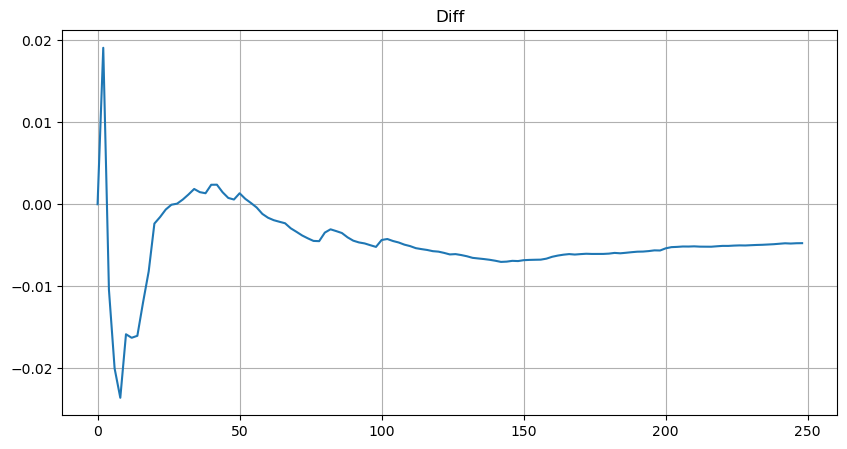

In [53]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title('Diff')
plt.plot(depths, probabilities_s-probabilities);

有了对成交量分布的估计方程，注意方程的概率不是真实的概率，而是一个条件概率。此时可以回答这个问题，如果下一笔订单发生，这个订单大于某个值的概率是多少？也可以说，不同深度的订单成交的概率是多少(理想情况，不那么严谨，理论上订单簿有新增订单和撤单，以及同深度有排队)。

写到这里篇幅已经差不多了，还有很多疑问需要解答，下面的系列文章将尝试给出答案。